# **Creación de data tabular de la señales fisiológicas obtenidas en los laboratorios**

In [1]:
#Importación de librerías
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import biosignalsnotebooks as bsnb
from scipy.signal import iirnotch
from scipy.signal import lfilter
import scipy

In [2]:
#Seleccionamos estilo de ploteo
plt.style.use("ggplot")


## Lectura de los datos

In [3]:
#Lectura de documento txt con tabulación (/t) como delimitador
array1 = np.genfromtxt("ECG_ejercicio.txt", delimiter="\t")
array1

array([[  0.,   0.,   0., ...,   0., 468.,  nan],
       [  1.,   0.,   0., ...,   0., 455.,  nan],
       [  2.,   0.,   0., ...,   0., 448.,  nan],
       ...,
       [ 11.,   0.,   0., ...,   0., 625.,  nan],
       [ 12.,   0.,   0., ...,   0., 624.,  nan],
       [ 13.,   0.,   0., ...,   0., 619.,  nan]])

In [4]:
#Nos quedamos con el dato del sensor
d_sensor = array1[:,-2]
d_sensor

array([468., 455., 448., ..., 625., 624., 619.])

# Definiendo Parámetros de la Señal Adquirida

In [5]:
resolution=10
Fs = 1000 #Frecuencia de muestreo del dispositivo de adquisición
Ts=1/Fs
n = np.arange(0,d_sensor.shape[0])  # t = n*Ts
t = n*Ts

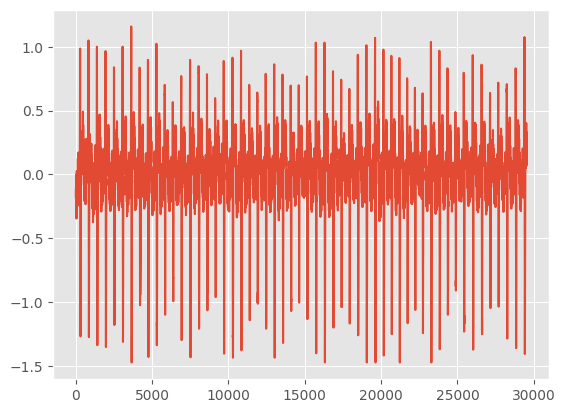

In [6]:
# Let's convert the signal's units, since we know it is a ECG signal
signal = bsnb.raw_to_phy("ECG", "biosignalsplux", d_sensor, resolution, "mV")
plt.plot(signal)


## Graficación de los datos

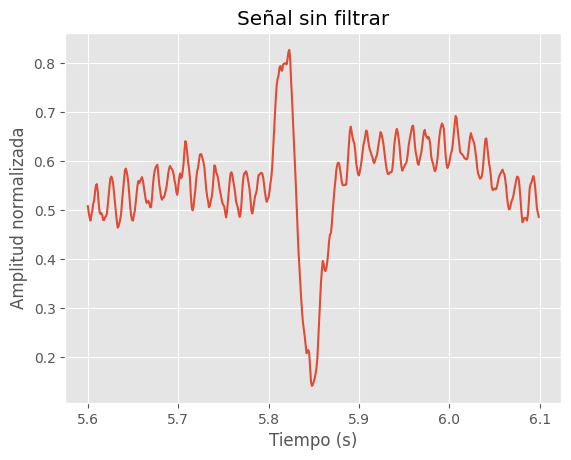

In [7]:
#plt.plot(t[0:500],d_sensor[0:500])
#plt.xlim(0,500)

senal_sin_filtrar_norm = d_sensor / max(abs(d_sensor)) #Se normalizan los valores
plt.plot(t[5600:6100],senal_sin_filtrar_norm[5600:6100], label='Señal sin filtrar')
plt.title("Señal sin filtrar")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud normalizada")

plt.savefig("señal_sin_filtrar.png")

# TRANSFORMADA DE FOURIER (Análisis Frecuencial)

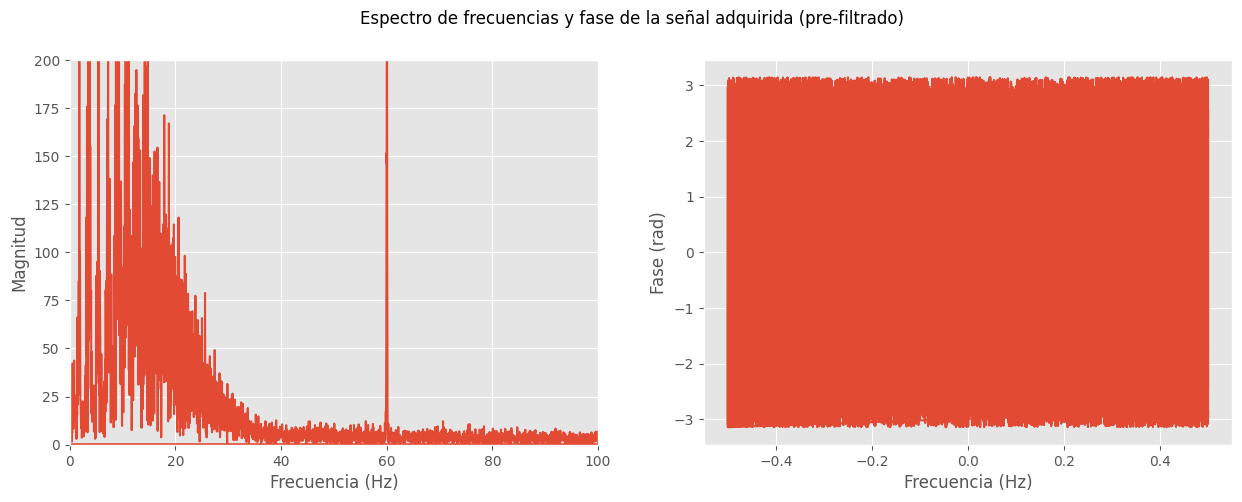

In [8]:
# Transformada de Fourier
fft_signal = np.fft.fft(senal_sin_filtrar_norm)

# Magnitud de la transformada de Fourier
mag_signal = np.abs(fft_signal)

# Fase de la transformada de Fourier
phase_signal = np.angle(fft_signal)

# Frecuencias
freqs = np.fft.fftfreq(len(senal_sin_filtrar_norm))

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(freqs*1000, mag_signal)
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Magnitud')
axs[0].set_ylim([0, 200])
axs[0].set_xlim([0, 100])

axs[1].plot(freqs, phase_signal)
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('Fase (rad)')

fig.suptitle("Espectro de frecuencias y fase de la señal adquirida (pre-filtrado)")

plt.savefig("espectro_before_filtering.png")

plt.show()

# Filtro Notch (Rechaza 60 Hz)

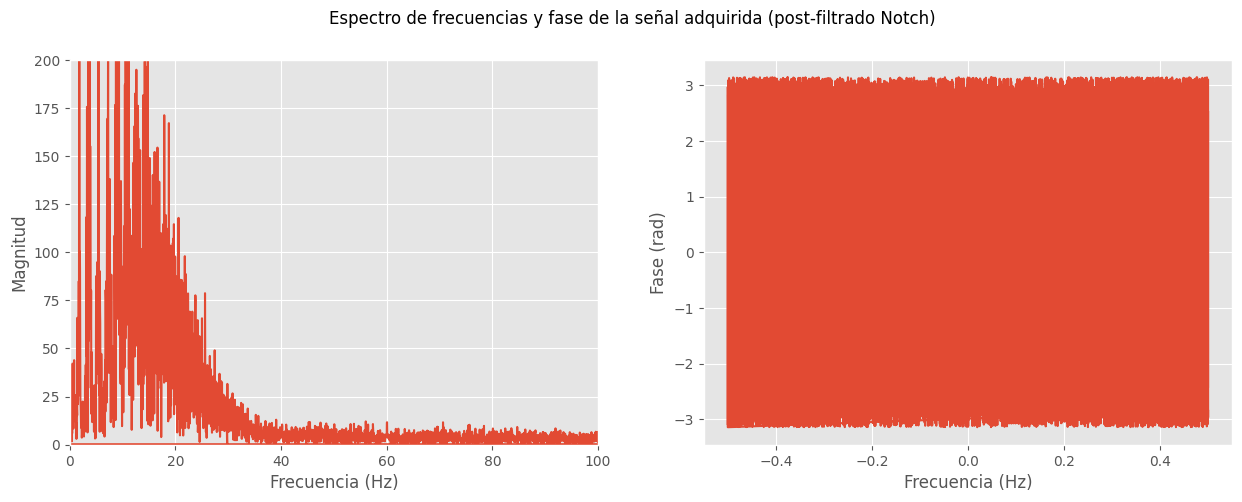

In [9]:
# Crear un filtro notch centrado en 60 Hz
f0 = 60.0  # frecuencia a eliminar
Q = 20.0  # factor de calidad
w0 = f0 / (Fs / 2)
b, a = iirnotch(w0, Q)

# Aplicar el filtro notch a la señal
senal_sin60Hz = scipy.signal.lfilter(b, a, senal_sin_filtrar_norm)

# Transformada de Fourier
fft_signal = np.fft.fft(senal_sin60Hz)

# Magnitud de la transformada de Fourier
mag_signal = np.abs(fft_signal)

# Fase de la transformada de Fourier
phase_signal = np.angle(fft_signal)

# Frecuencias
freqs = np.fft.fftfreq(len(senal_sin60Hz))

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(freqs*1000, mag_signal)
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Magnitud')
axs[0].set_ylim([0, 200])
axs[0].set_xlim([0, 100])

axs[1].plot(freqs, phase_signal)
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('Fase (rad)')

fig.suptitle("Espectro de frecuencias y fase de la señal adquirida (post-filtrado Notch)")

plt.savefig("filtrado_notch.png")

plt.show()

#senal_sin60Hz=senal_sin_filtrar_norm // usar para eliminar el filtrado notch y ver el efecto sin este filtro

# Creando los Filtros (a partir de la libreria Bitalino)

In [10]:

# Creating a Butterworth filter with order 3 and low-pass frequency of 100 Hz
lfilter_signal = bsnb.lowpass(senal_sin60Hz, 100, order=3)
filtfilt_signal = bsnb.lowpass(senal_sin60Hz, 100, order=3, use_filtfilt=True)


# Filtrado Normal con Pasabajas

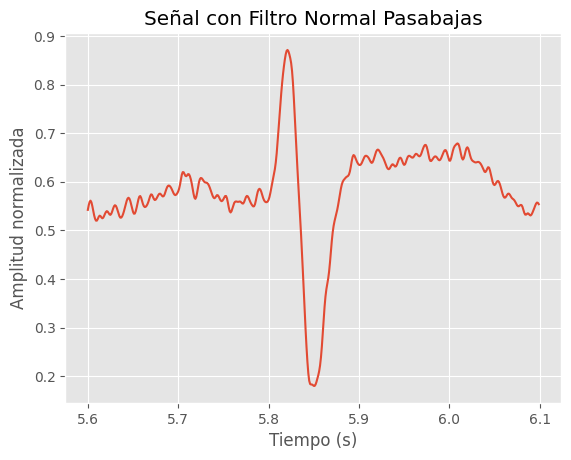

In [11]:

lfilter_signal = lfilter_signal / max(abs(lfilter_signal))
plt.plot(t[5600:6100],lfilter_signal[5600:6100])
plt.title("Señal con Filtro Normal Pasabajas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud normalizada")

plt.savefig("filtrado_normal.png")

# Filtrado "filtfilt"

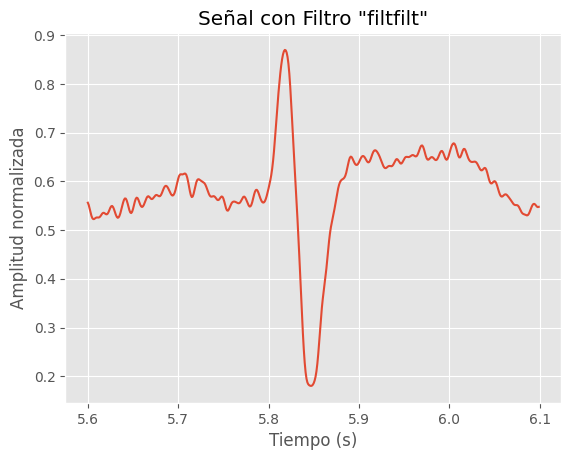

In [12]:

filtfilt_signal = filtfilt_signal / max(abs(filtfilt_signal))
plt.plot(t[5600:6100],filtfilt_signal[5600:6100])
plt.title('Señal con Filtro "filtfilt"')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud normalizada")

plt.savefig("filtrado_filtfilt.png")


# Comprobando la Efectividad de los Filtros

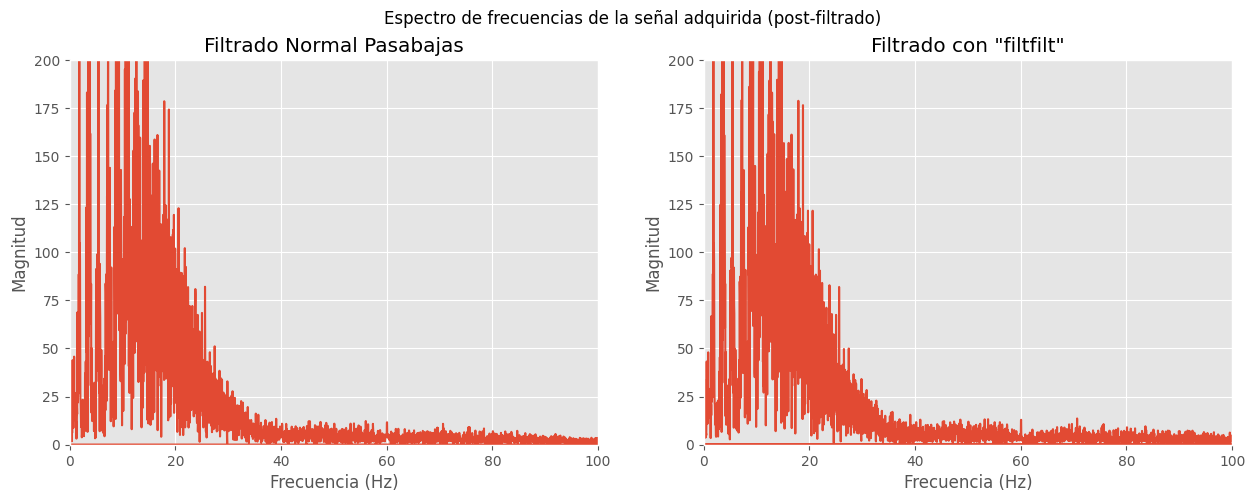

In [13]:
# Transformadas de Fourier
fft_signal_1 = np.fft.fft(filtfilt_signal)
fft_signal_2 = np.fft.fft(lfilter_signal)

# Magnitud de la transformada de Fourier
mag_signal_1 = np.abs(fft_signal_1)
mag_signal_2 = np.abs(fft_signal_2)

# Frecuencias
freqs_1 = np.fft.fftfreq(len(filtfilt_signal))
freqs_2 = np.fft.fftfreq(len(lfilter_signal))

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Configurar títulos de subplots
axs[0].set_title('Filtrado Normal Pasabajas')
axs[1].set_title('Filtrado con "filtfilt"')

axs[0].plot(freqs_1*1000, mag_signal_1)
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Magnitud')
axs[0].set_ylim([0, 200])
axs[0].set_xlim([0, 100])

axs[1].plot(freqs_2*1000, mag_signal_2)
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('Magnitud')
axs[1].set_ylim([0, 200])
axs[1].set_xlim([0, 100])

fig.suptitle("Espectro de frecuencias de la señal adquirida (post-filtrado)")

plt.savefig("espectro_after_filtering.png")

plt.show()

# PLOTEANDO SEÑALES (Sin filtro / Con filtro 1 / Con filtro 2)

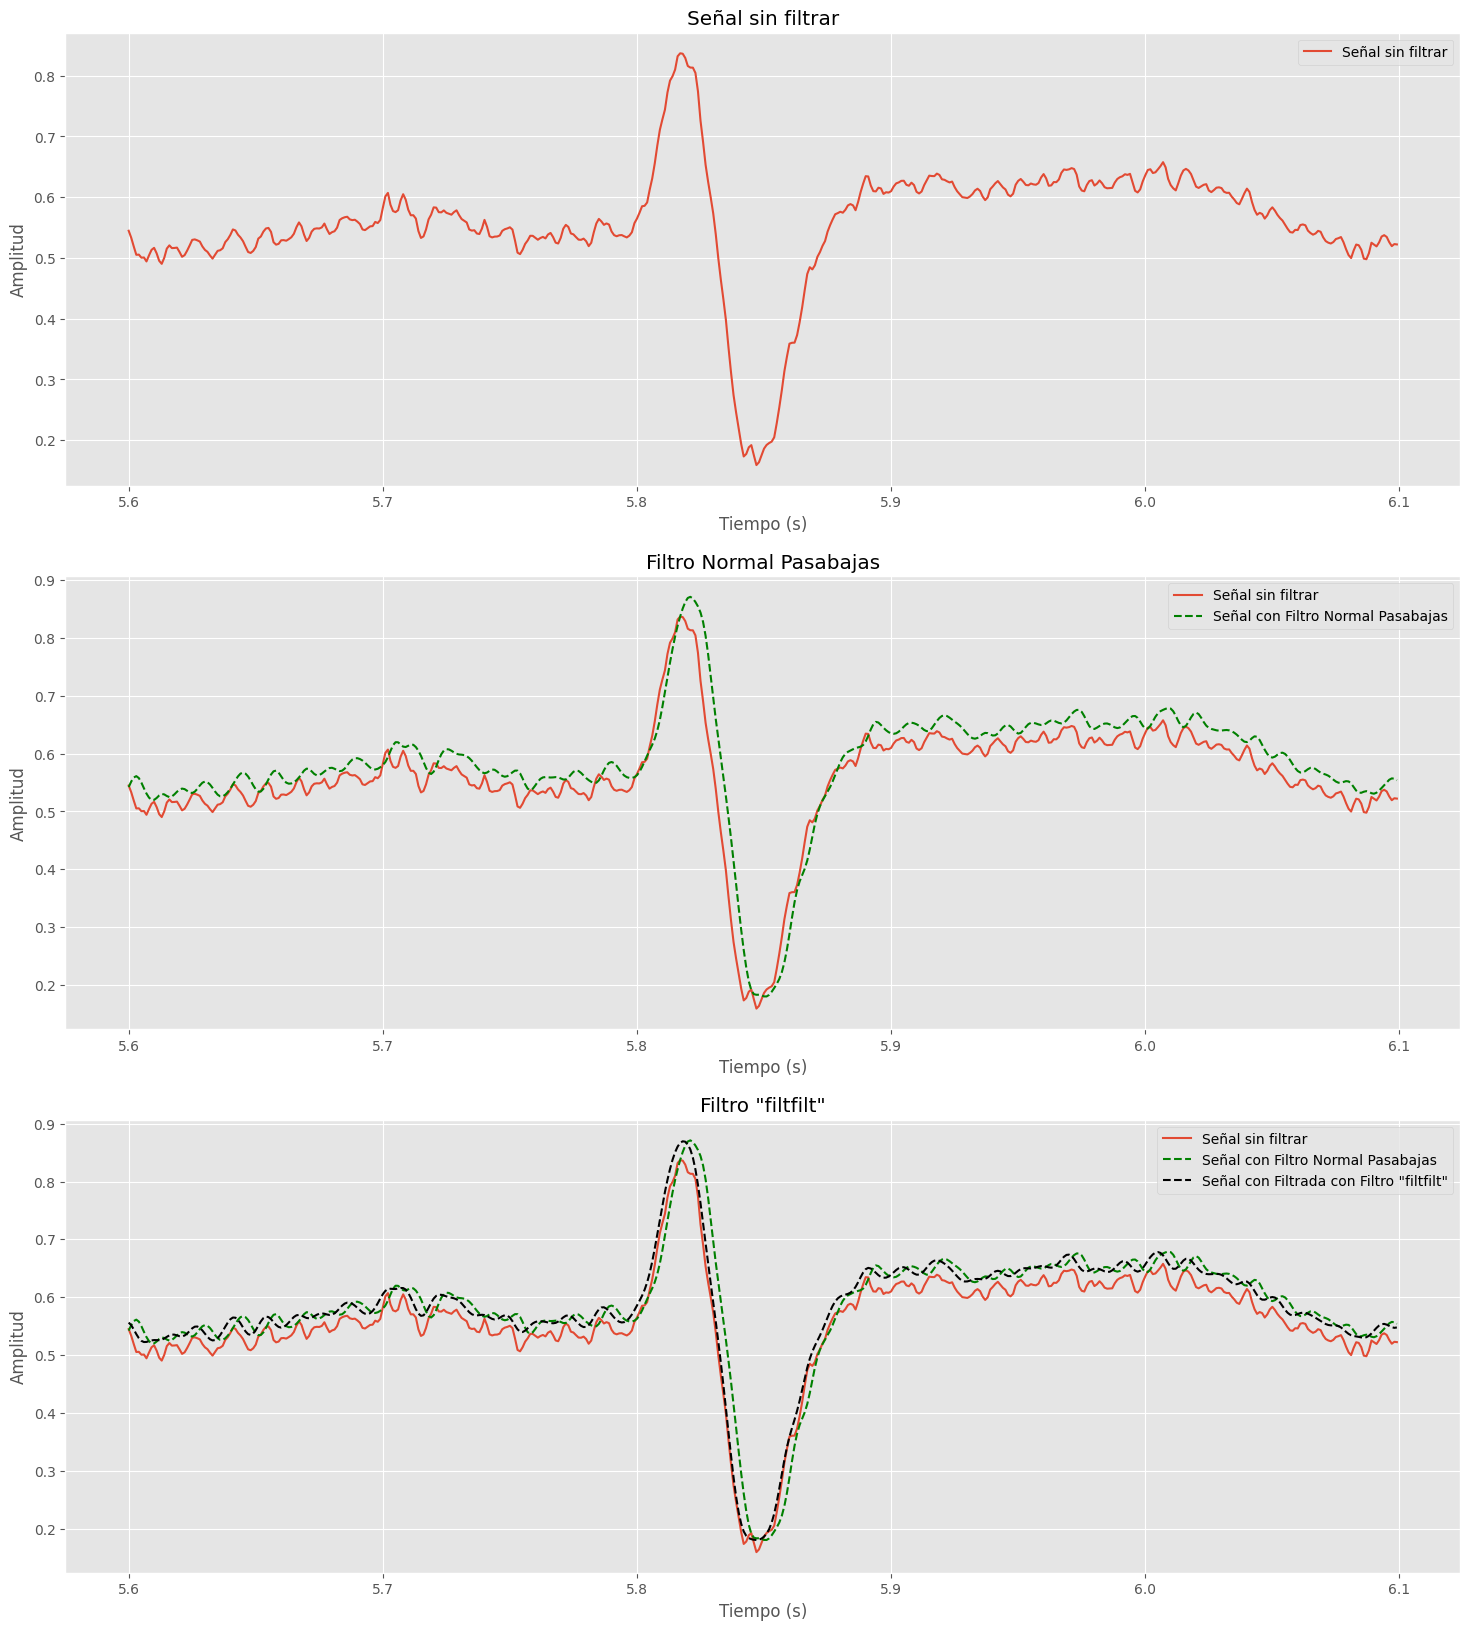

In [14]:
# Límites para mostrar
m=5600; #límite inferior
n=6100; #límite superior

# Le damos nuevas variables para el procesamiento
senal_filtro1_corr = lfilter_signal
senal_filtro2_corr = filtfilt_signal

# Crear figura y subplots
fig, axs = plt.subplots(3, 1, figsize=(18, 20))

# Configurar títulos de subplots
axs[0].set_title('Señal sin filtrar')
axs[1].set_title('Filtro Normal Pasabajas')
axs[2].set_title('Filtro "filtfilt"')

# Graficar señal sin filtrar
axs[0].plot(t[m:n], senal_sin60Hz[m:n], label='Señal sin filtrar')
axs[0].set_xlabel('Tiempo (s)')
axs[0].set_ylabel('Amplitud')
axs[0].legend()

# Graficar filtro 1
axs[1].plot(t[m:n], senal_sin60Hz[m:n], label='Señal sin filtrar')
axs[1].plot(t[m:n], senal_filtro1_corr[m:n], label='Señal con Filtro Normal Pasabajas',linestyle='--', color="green")
axs[1].set_xlabel('Tiempo (s)')
axs[1].set_ylabel('Amplitud')
axs[1].legend()

# Graficar filtro 2
axs[2].plot(t[m:n], senal_sin60Hz[m:n], label='Señal sin filtrar')
axs[2].plot(t[m:n], senal_filtro1_corr[m:n], label='Señal con Filtro Normal Pasabajas',linestyle='--', color="green")
axs[2].plot(t[m:n], senal_filtro2_corr[m:n], label='Señal con Filtrada con Filtro "filtfilt"',linestyle='--', color="black")
axs[2].set_xlabel('Tiempo (s)')
axs[2].set_ylabel('Amplitud')
axs[2].legend()

plt.savefig("comparativa_3x1.png")

# Mostrar plot
plt.show()

## Especificar la Frecuencia de muestreo 

In [15]:
Fs = 1000 #Frecuencia de muestreo del dispositivo de adquisición
Ts=1/Fs
n = np.arange(0,d_sensor.shape[0])  # t = n*Ts
t = n*Ts

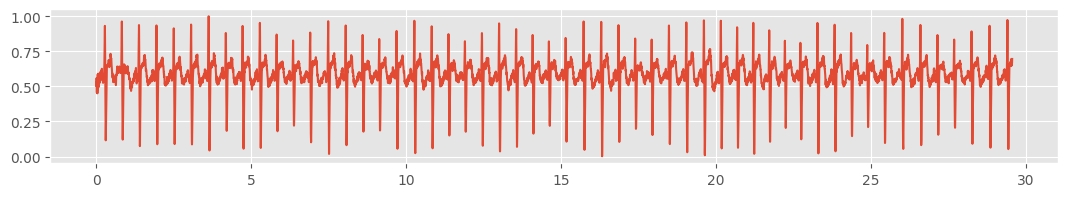

In [16]:
#Ploteamos la señal en el tiempo
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, senal_filtro2_corr)

## Pasando el array a pandas para trabajarlo como series de tiempo

In [17]:
#Pasamos las observaciones a filas correspondientes a una variable t y d_sensor
st_sensor = np.concatenate((t.reshape(-1,1),  senal_filtro2_corr.reshape(-1,1)), axis=1)

In [18]:
#Creamos el data frame con las varibles t y d_sensor
df = pd.DataFrame(st_sensor, columns=["t","senal_filtro2_corr"])
df.head()

,t,senal_filtro2_corr
0,0.000,0.528126
1,0.001,0.515680
2,0.002,0.506180
3,0.003,0.501750
4,0.004,0.503101


In [19]:
#Establecemos t como index 
df = df.set_index("t")
df.head()

,senal_filtro2_corr
t,
0.000,0.528126
0.001,0.515680
0.002,0.506180
0.003,0.501750
0.004,0.503101


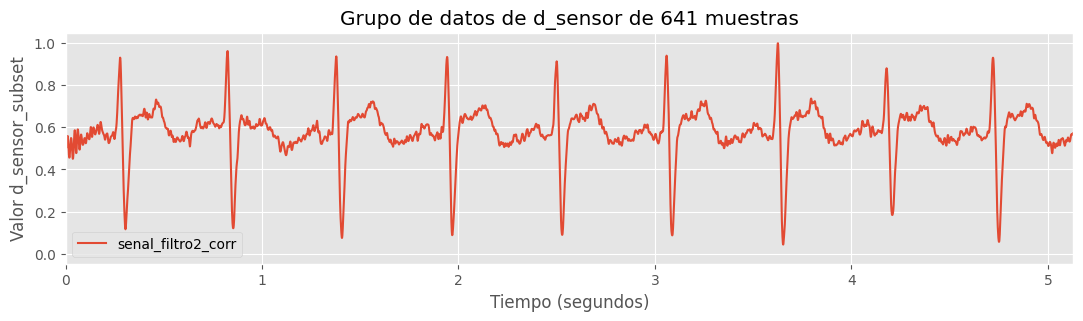

In [20]:
#Ploteamos la señal

df.plot(figsize=(13,3))
plt.xlim(0,5.128)
#####plt.plot(df.index, df.loc[936])#######
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Valor d_sensor_subset")  # Cambiar el nombre del eje y
plt.title("Grupo de datos de d_sensor de 641 muestras")  # Cambiar el título
plt.show()


## Pasando a data tabular estilo Sklearn

In [21]:
df.index.max()/0.64

46.1703125

In [22]:
df.shape[0]/22

1343.1818181818182

In [23]:
d_obs = df["senal_filtro2_corr"].values[:5128].reshape(8, 641)
d_obs

array([[0.528126  , 0.51568037, 0.50618033, ..., 0.55443811, 0.5630602 ,
        0.569153  ],
       [0.57318606, 0.57599929, 0.57832278, ..., 0.62997208, 0.63145868,
        0.62801685],
       [0.61989334, 0.60855943, 0.5963613 , ..., 0.57841968, 0.57924427,
        0.58444639],
       ...,
       [0.64416097, 0.63954686, 0.63683713, ..., 0.65101047, 0.64934885,
        0.6470136 ],
       [0.6446998 , 0.64332848, 0.64359964, ..., 0.51493899, 0.5200228 ,
        0.52776189],
       [0.53702985, 0.5465173 , 0.55489946, ..., 0.56756659, 0.56987446,
        0.57182293]])

<Figure size 1300x200 with 0 Axes>

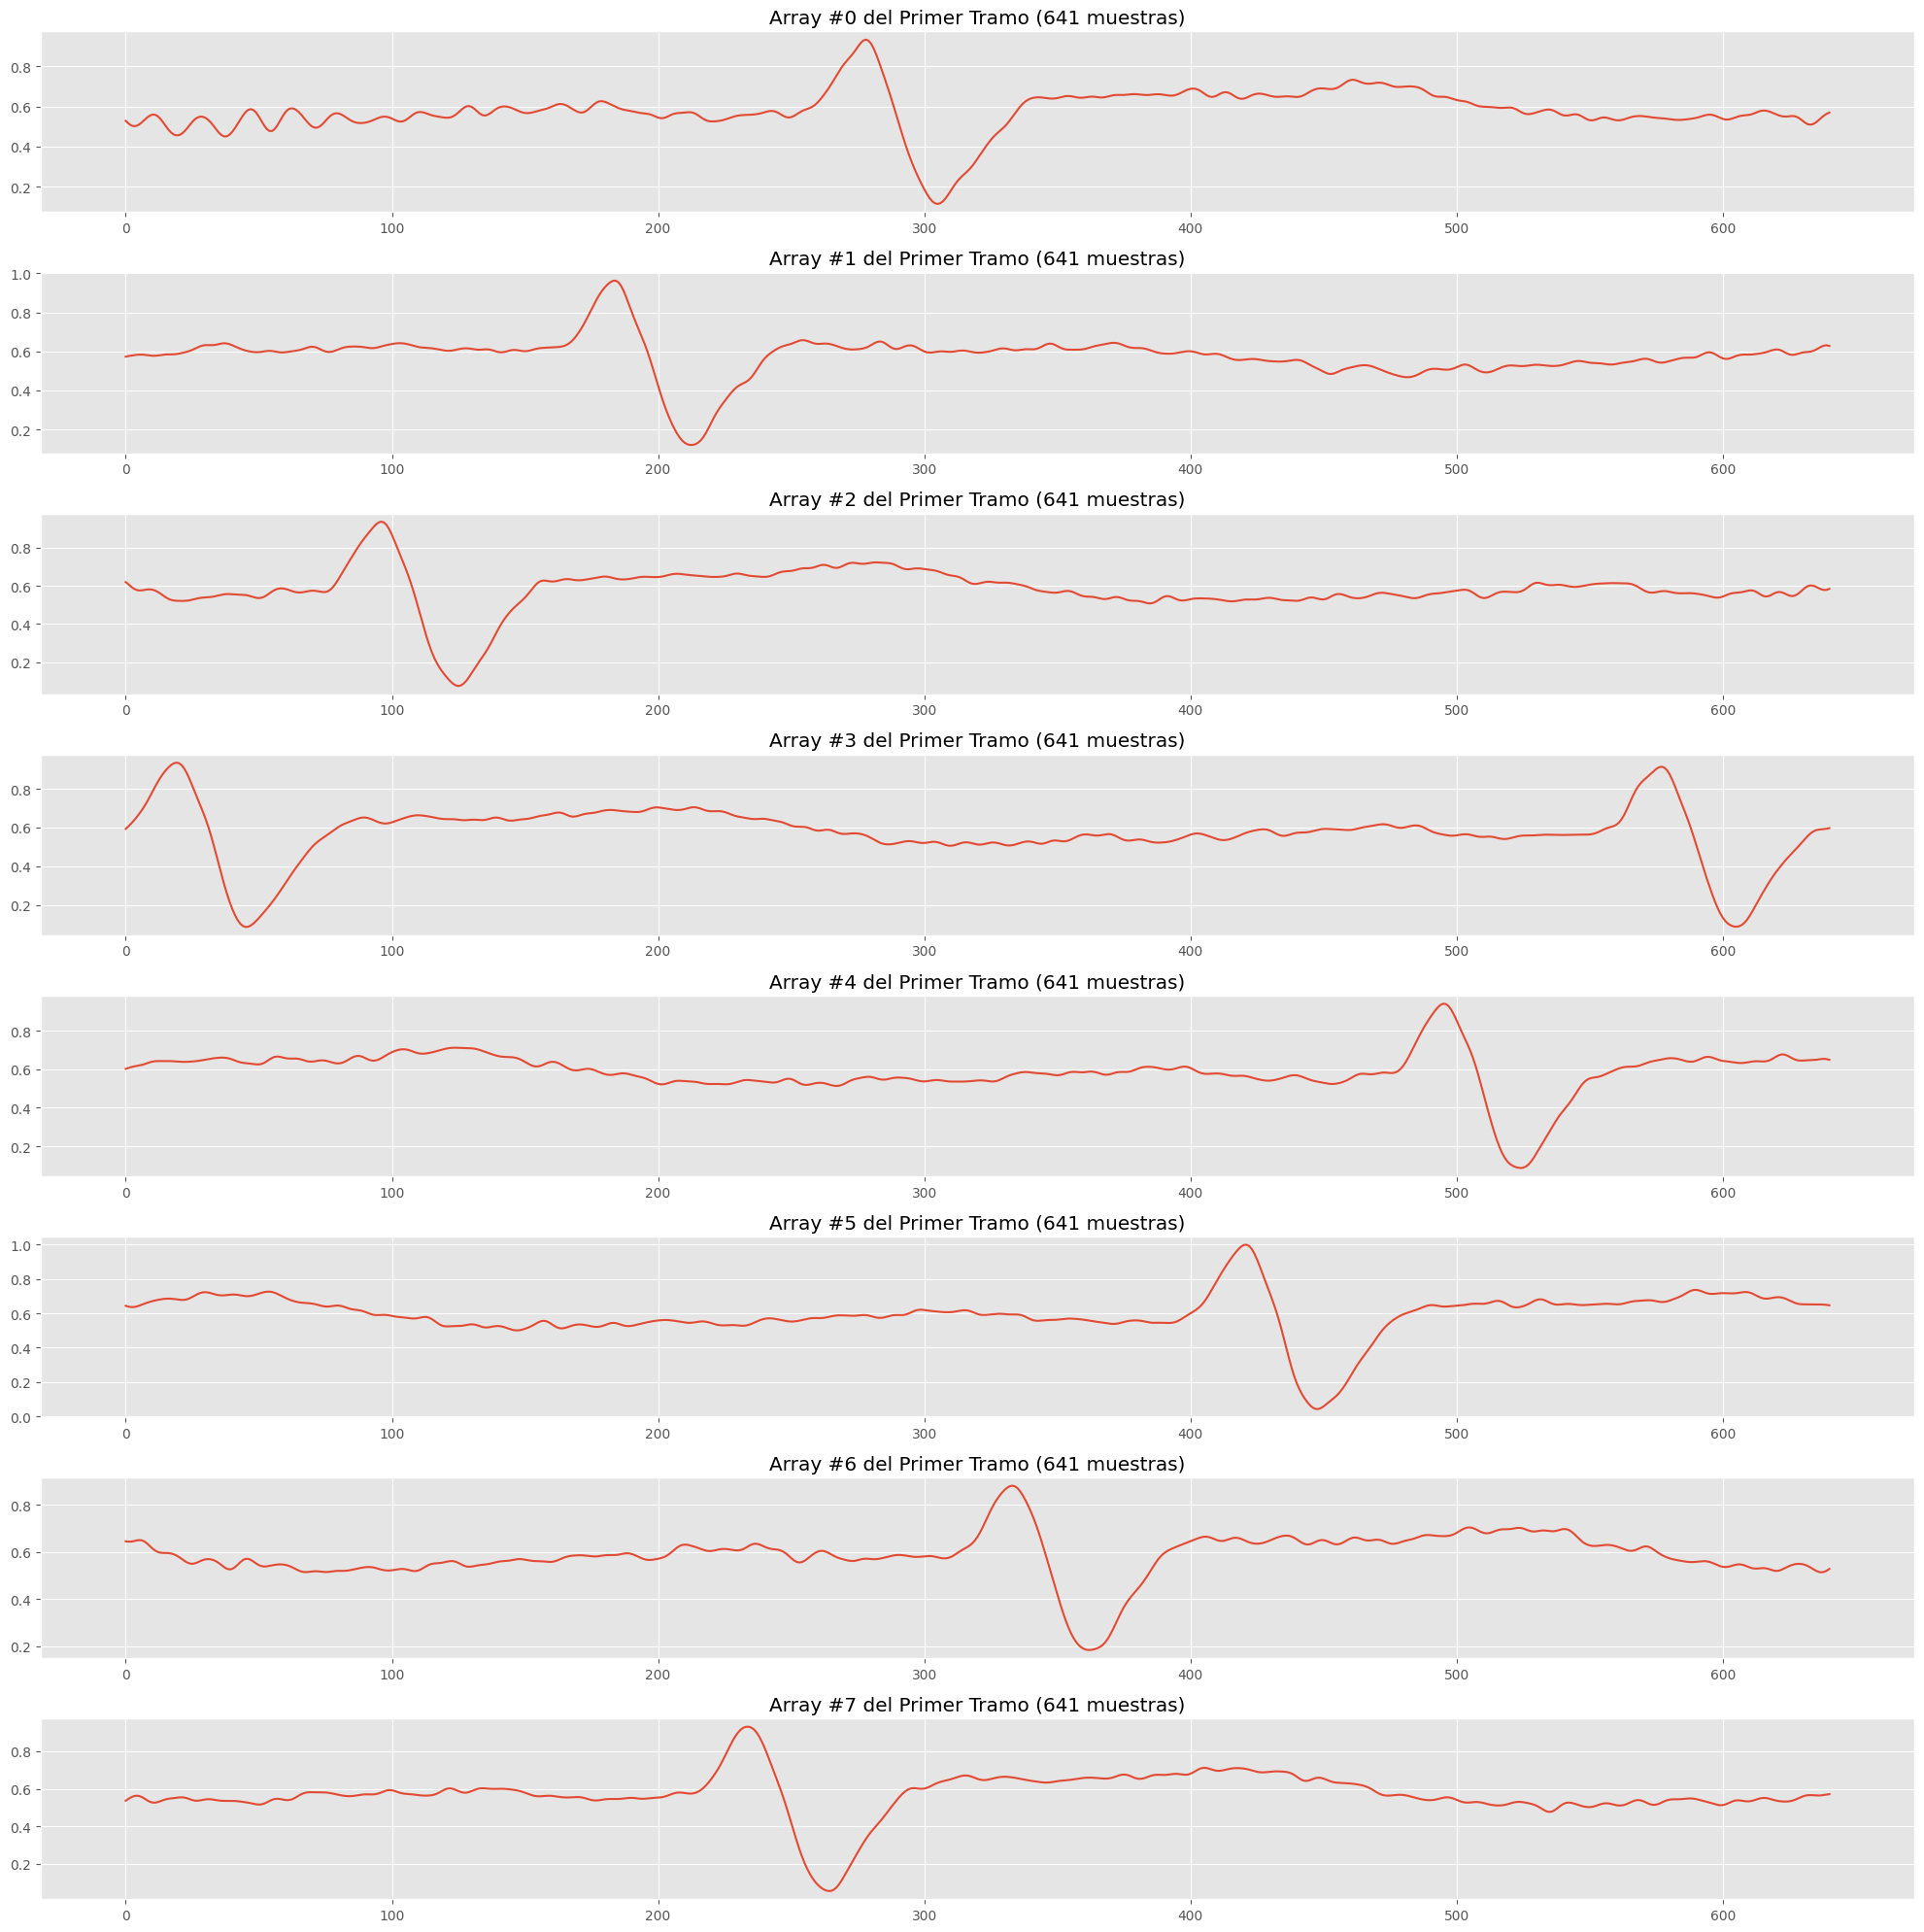

In [24]:
#plt.figure(figsize=(15,2))
#plt.plot(d_obs[7])
plt.figure(figsize=(13,2))
#plt.plot(d_obs[])

fig, axs = plt.subplots(nrows=8, figsize=(20, 20))

for i in range(8):
    axs[i].plot(d_obs[i])
    axs[i].set_title(f"Array #{i} del Primer Tramo (641 muestras)")
    
plt.tight_layout()
plt.show()

In [25]:
################ SEGUNDO GRUPO
Fs = 1000 #Frecuencia de muestreo del dispositivo de adquisición
Ts=1/Fs
n = np.arange(0,5400)  # t = n*Ts
t_2 = n*Ts
len(t_2)
t_2

# Seleccionar valores desde el índice 4487 hasta el final de la columna "d_sensor"
d_sensor_subset = df["senal_filtro2_corr"].values[5128:10528]
len(d_sensor_subset)
d_sensor_subset


array([0.57279328, 0.57243545, 0.57082361, ..., 0.54497671, 0.54087176,
       0.53616238])

In [26]:
################ TERCER GRUPO
n = np.arange(0,3400)  # t = n*Ts
t_3 = n*Ts
len(t_3)
t_3

# Seleccionar valores desde el índice 4487 hasta el final de la columna "d_sensor"
d_sensor_subset_2 = df["senal_filtro2_corr"].values[10528:13928] #5 de 650=3250
len(d_sensor_subset_2)
d_sensor_subset_2


array([0.53187498, 0.52864671, 0.52668097, ..., 0.54156076, 0.54232202,
       0.54278915])

In [27]:
################ SEGUNDO GRUPO
#Pasamos las observaciones a filas correspondientes a una variable t y d_sensor
st_sensor_2 = np.concatenate((t_2.reshape(-1,1),  d_sensor_subset.reshape(-1,1)), axis=1)

#Creamos el data frame con las varibles t y d_sensor
df_2 = pd.DataFrame(st_sensor_2, columns=["t_2","d_sensor_subset"])
df_2.head()

# Establecer t_2 como índice
df_2 = df_2.set_index("t_2")
df_2.head()

df_2


,d_sensor_subset
t_2,
0.000,0.572793
0.001,0.572435
0.002,0.570824
0.003,0.568556
0.004,0.566649
...,...
5.395,0.547289
5.396,0.547365
5.397,0.544977


In [28]:

################ TERCER GRUPO
#Pasamos las observaciones a filas correspondientes a una variable t y d_sensor
st_sensor_3 = np.concatenate((t_3.reshape(-1,1),  d_sensor_subset_2.reshape(-1,1)), axis=1)

#Creamos el data frame con las varibles t y d_sensor
df_3 = pd.DataFrame(st_sensor_3, columns=["t_3","d_sensor_subset_2"])
df_3.head()

# Establecer t_2 como índice
df_3 = df_3.set_index("t_3")
df_3.head()

df_3


,d_sensor_subset_2
t_3,
0.000,0.531875
0.001,0.528647
0.002,0.526681
0.003,0.525853
0.004,0.525792
...,...
3.395,0.538985
3.396,0.540308
3.397,0.541561


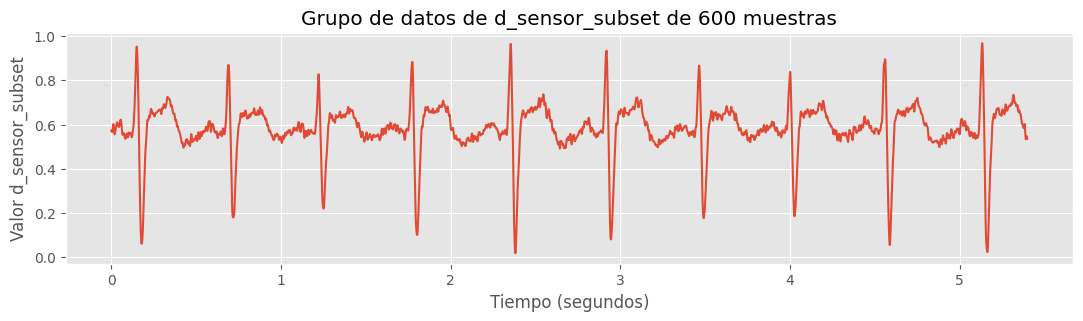

In [29]:

# Graficar los valores de d_sensor_subset correspondientes al primer segundo
plt.figure(figsize=(13, 3))
plt.plot(df_2)
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Valor d_sensor_subset")  # Cambiar el nombre del eje y
plt.title("Grupo de datos de d_sensor_subset de 600 muestras")  # Cambiar el título
plt.show()


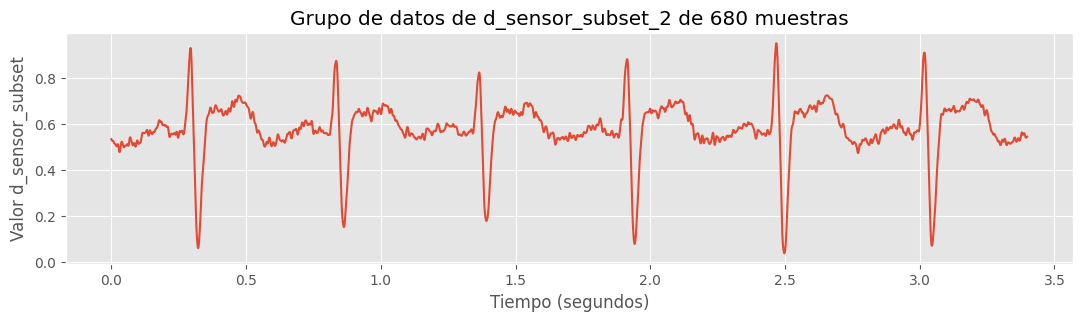

In [30]:

# Graficar los valores de d_sensor_subset correspondientes al primer segundo
plt.figure(figsize=(13, 3))
plt.plot(df_3)
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Valor d_sensor_subset")  # Cambiar el nombre del eje y
plt.title("Grupo de datos de d_sensor_subset_2 de 680 muestras")  # Cambiar el título
plt.show()


In [31]:
len(df_2)/600

9.0

In [32]:
len(df_3)/680

5.0

In [33]:
d_obs_2 = df["senal_filtro2_corr"].values[5128:10528].reshape(9, 600)
d_obs_2

array([[0.57279328, 0.57243545, 0.57082361, ..., 0.60134242, 0.60011244,
        0.59915994],
       [0.59808267, 0.59629855, 0.59335938, ..., 0.55927567, 0.55776965,
        0.55743091],
       [0.55895452, 0.56272789, 0.56878063, ..., 0.13255692, 0.12304789,
        0.11555928],
       ...,
       [0.62254856, 0.62804297, 0.63482172, ..., 0.70623822, 0.70341357,
        0.69969423],
       [0.69533902, 0.69021836, 0.68413176, ..., 0.59670071, 0.59850324,
        0.60091595],
       [0.60345122, 0.60555909, 0.60667566, ..., 0.54497671, 0.54087176,
        0.53616238]])

In [34]:
d_obs_3 = df["senal_filtro2_corr"].values[10528:13928].reshape(5, 680)
d_obs_3


array([[0.53187498, 0.52864671, 0.52668097, ..., 0.57101446, 0.57127032,
        0.57134215],
       [0.57161094, 0.5722916 , 0.57340839, ..., 0.75468615, 0.76986202,
        0.78160531],
       [0.79042876, 0.79763176, 0.80454688, ..., 0.66118435, 0.66423448,
        0.66765555],
       [0.67122947, 0.67406623, 0.67520877, ..., 0.59651937, 0.59237563,
        0.58658337],
       [0.57959371, 0.57202422, 0.56455365, ..., 0.54156076, 0.54232202,
        0.54278915]])

<Figure size 1300x200 with 0 Axes>

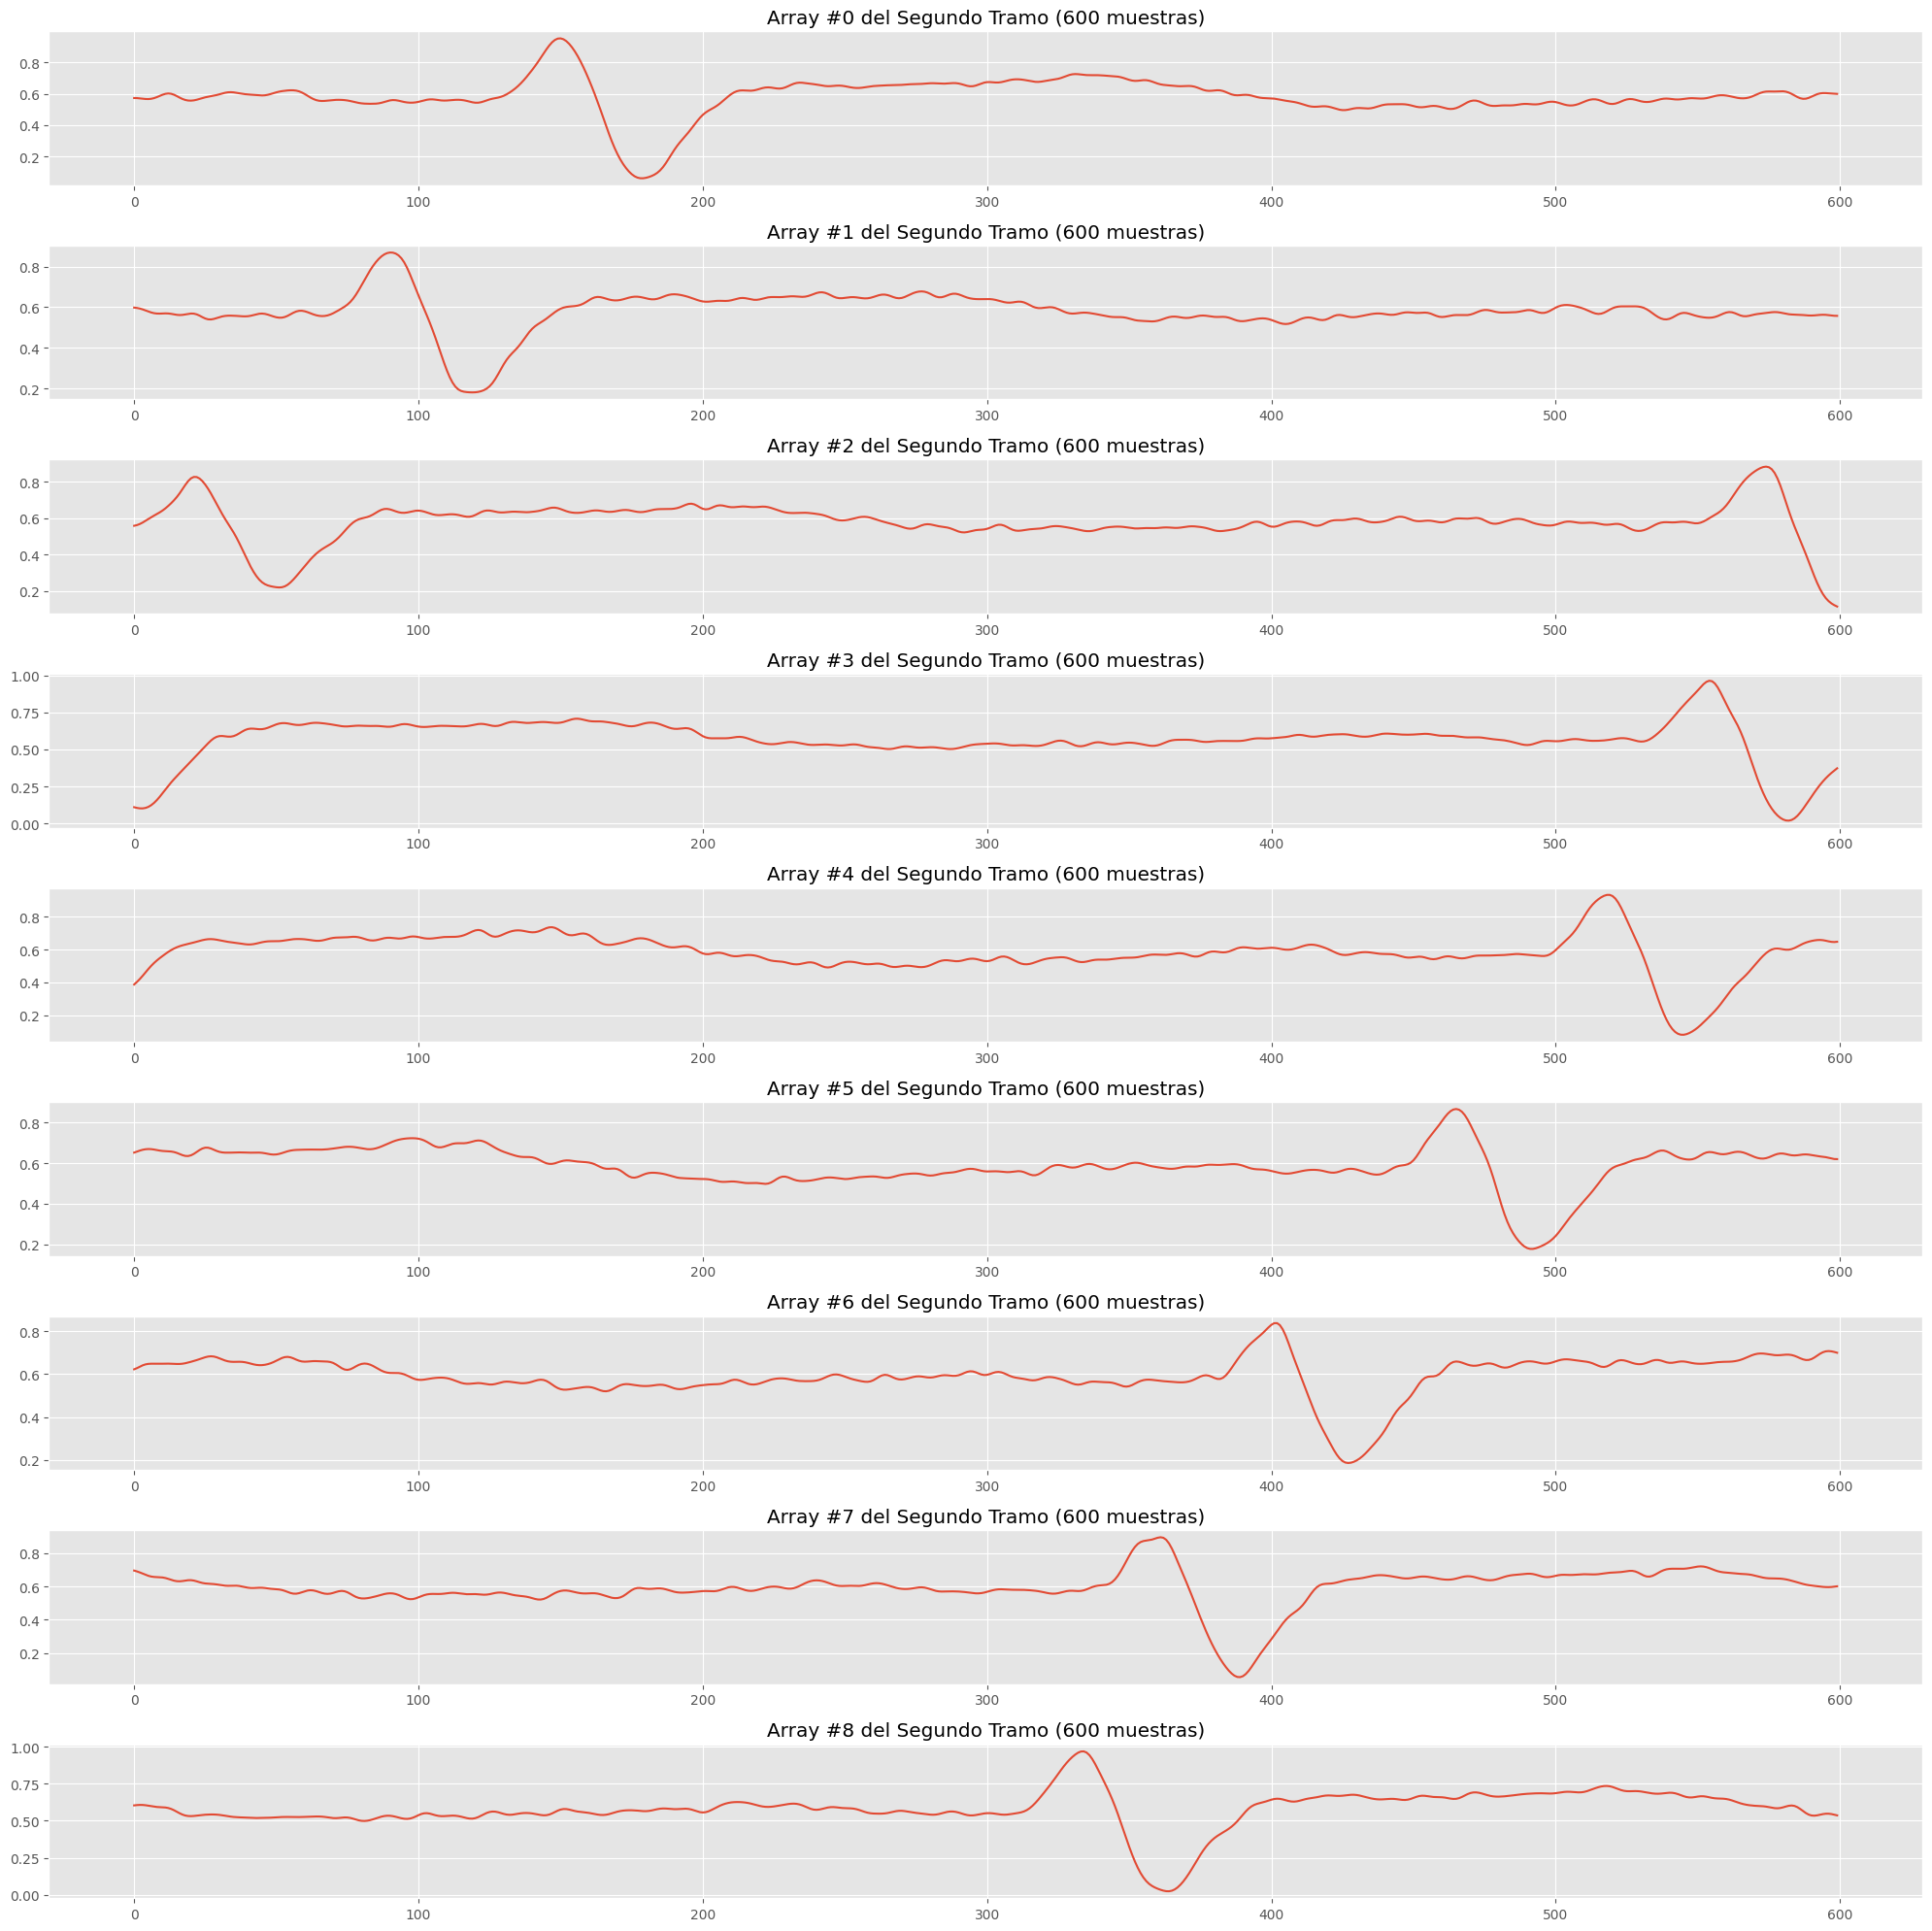

(9, 600)

In [35]:
plt.figure(figsize=(13,2))
#plt.plot(d_obs_2[8])


fig, axs = plt.subplots(nrows=9, figsize=(20, 20))

for i in range(9):
    axs[i].plot(d_obs_2[i])
    axs[i].set_title(f"Array #{i} del Segundo Tramo (600 muestras)")
    
plt.tight_layout()
plt.show()

d_obs_2.shape

<Figure size 1300x200 with 0 Axes>

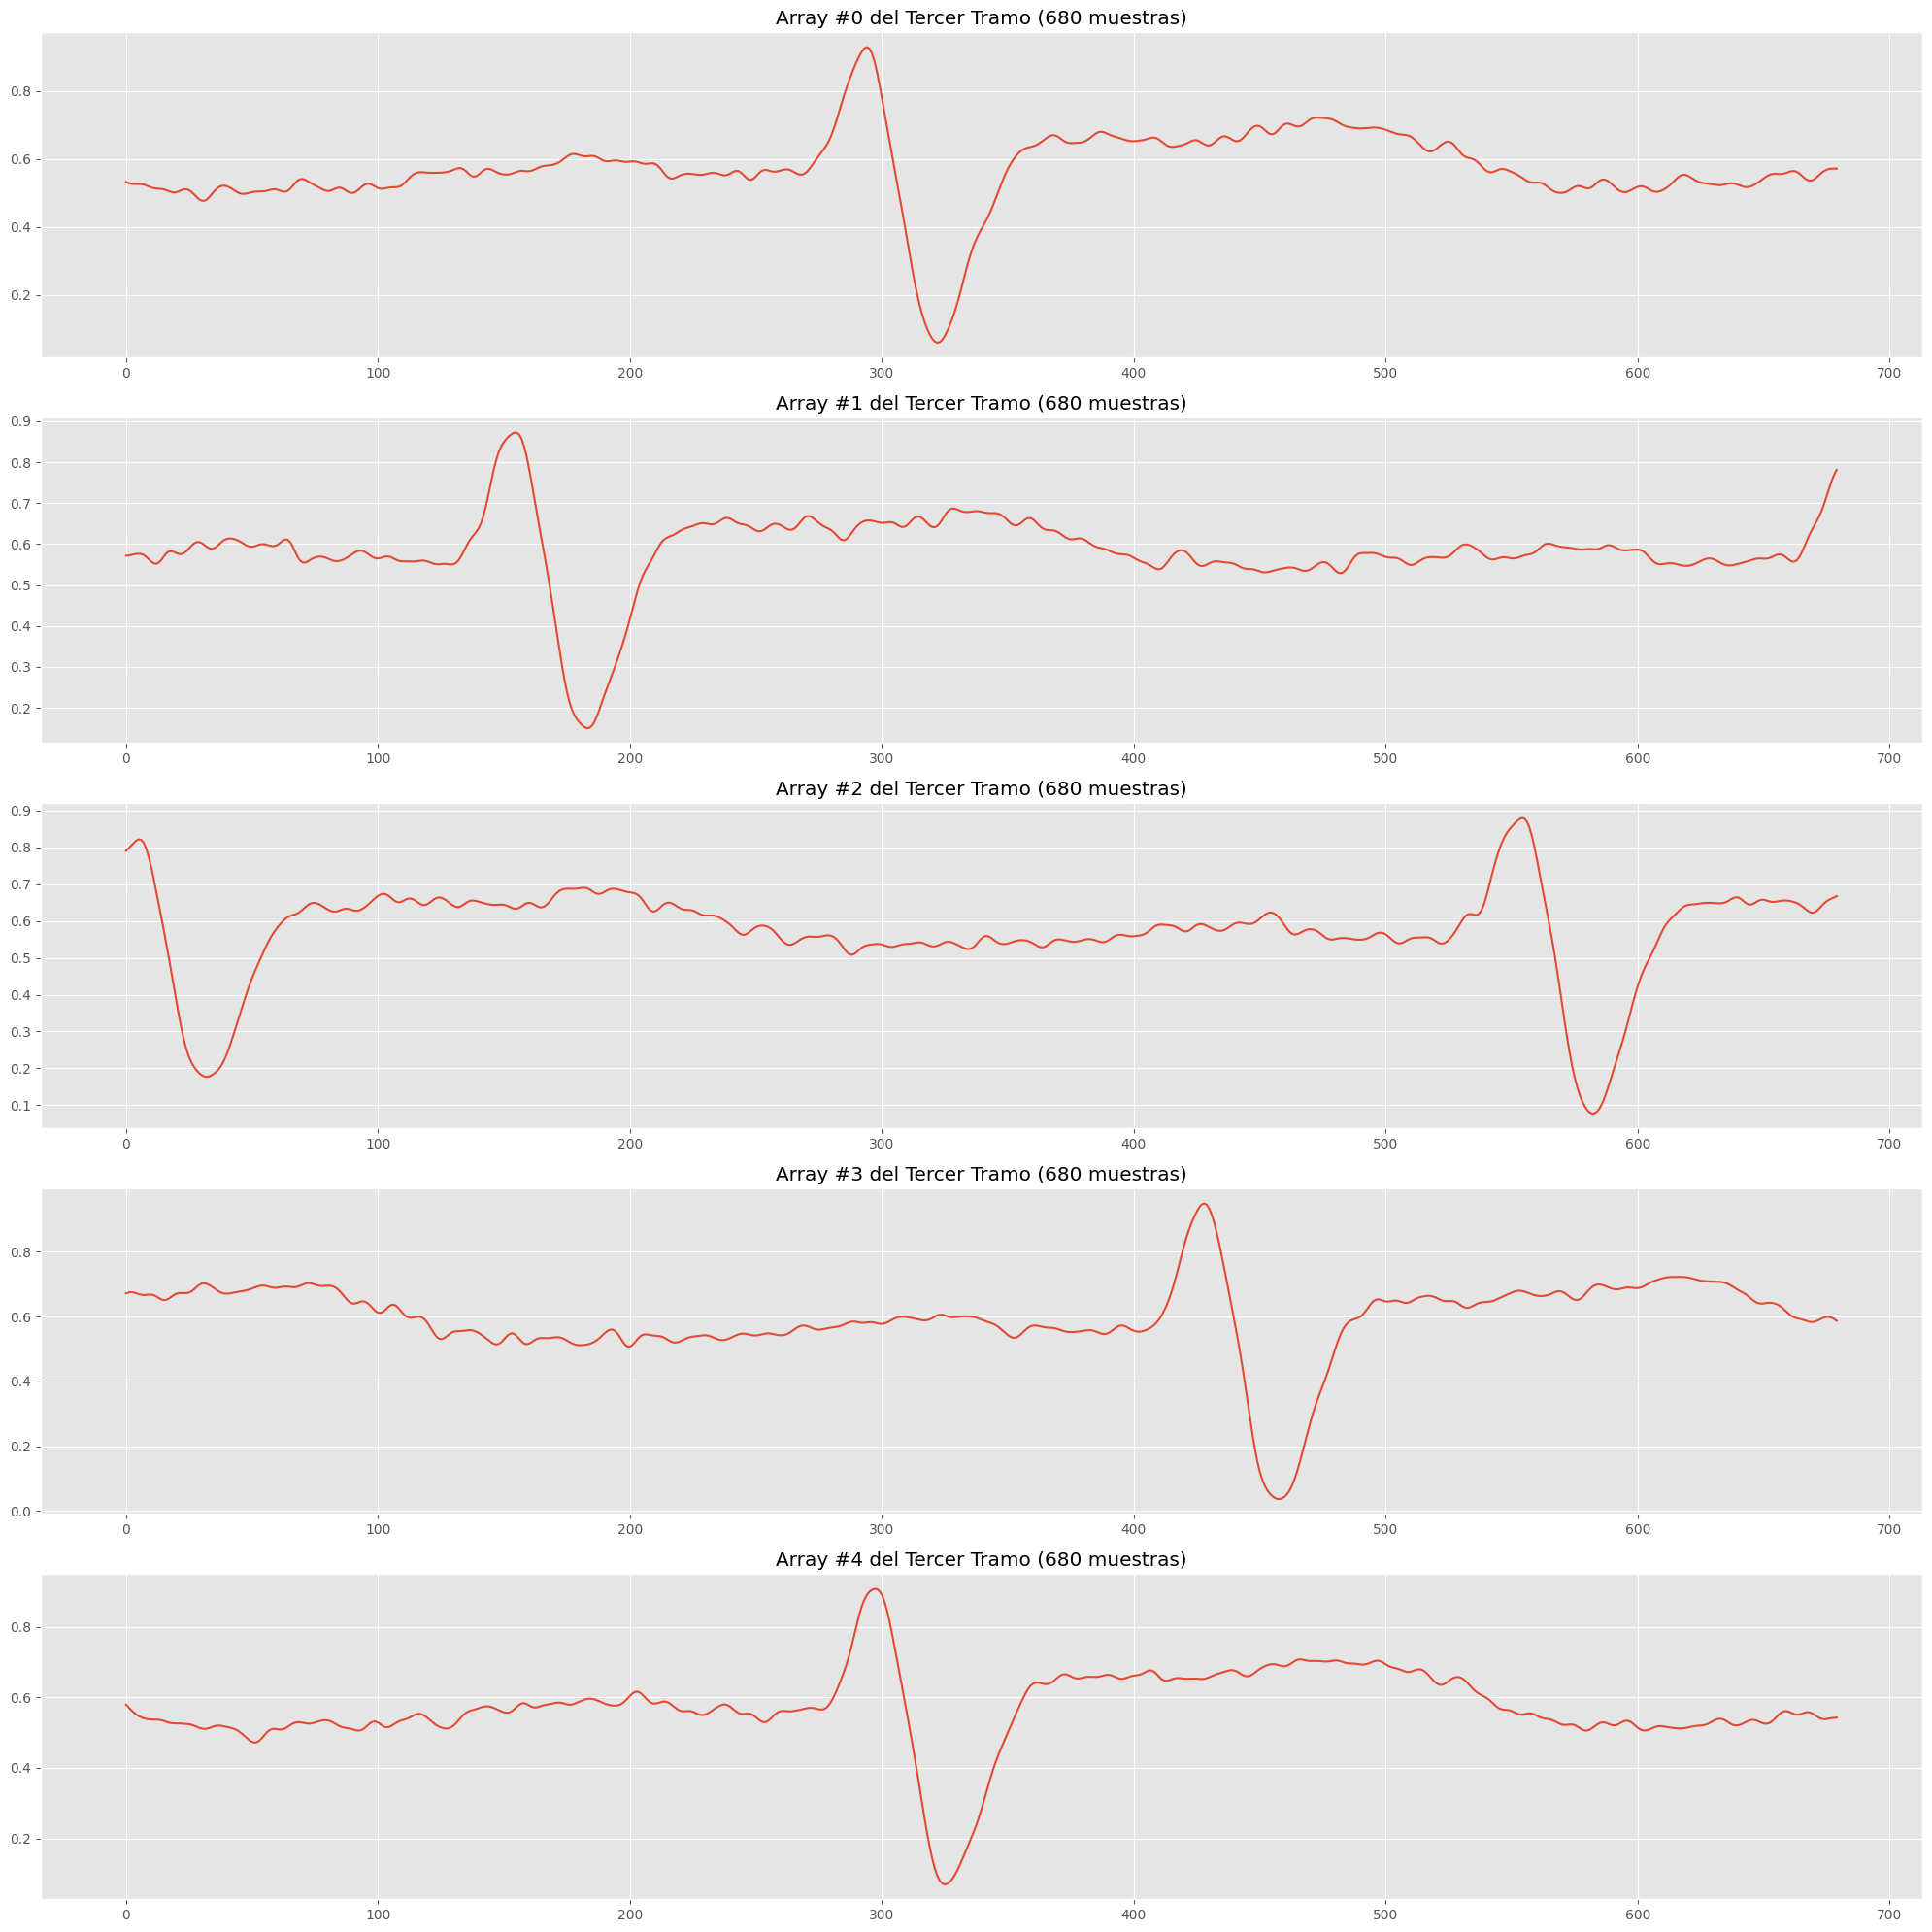

(5, 680)

In [36]:
plt.figure(figsize=(13,2))
#plt.plot(d_obs_3[4])

fig, axs = plt.subplots(nrows=5, figsize=(20, 20))

for i in range(5):
    axs[i].plot(d_obs_3[i])
    axs[i].set_title(f"Array #{i} del Tercer Tramo (680 muestras)")
    
plt.tight_layout()
plt.show()

d_obs_3.shape

In [37]:
# Tamaño requerido para los subarrays
tamano_subarray = 680

# Agregar ceros al final de los subarrays en array1 y array2
d_obs = np.concatenate((d_obs, np.zeros((8, tamano_subarray - d_obs.shape[1]))), axis=1)
d_obs_2 = np.concatenate((d_obs_2, np.zeros((9, tamano_subarray - d_obs_2.shape[1]))), axis=1)

# Concatenar los arrays en uno solo
array_ecgbasal = np.concatenate((d_obs, d_obs_2, d_obs_3), axis=0)
array_ecgbasal

array([[0.528126  , 0.51568037, 0.50618033, ..., 0.        , 0.        ,
        0.        ],
       [0.57318606, 0.57599929, 0.57832278, ..., 0.        , 0.        ,
        0.        ],
       [0.61989334, 0.60855943, 0.5963613 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.79042876, 0.79763176, 0.80454688, ..., 0.66118435, 0.66423448,
        0.66765555],
       [0.67122947, 0.67406623, 0.67520877, ..., 0.59651937, 0.59237563,
        0.58658337],
       [0.57959371, 0.57202422, 0.56455365, ..., 0.54156076, 0.54232202,
        0.54278915]])

In [38]:
np.save('array_ecgbasal.npy', array_ecgbasal)
len(array_ecgbasal)
len(d_obs[1])

680

## Descripción de categoria de los ejercicios realizado en la clase de ECG

| Descripción | Categoria |
|----------|----------|
| Basal    | 0   |
| Respiracion   | 1   | 
| Post-Ejercicio    | 2   |


In [39]:
#array4 = np.concatenate((array3,  np.repeat(0, array3.shape[0]).reshape(-1,1)), axis=1)

# Creamos una categoría
target_0 = np.repeat(0, array_ecgbasal.shape[0])
target_0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
ecg_basal = {"base": array_ecgbasal, "target": target_0}
ecg_basal

{'base': array([[0.528126  , 0.51568037, 0.50618033, ..., 0.        , 0.        ,
         0.        ],
        [0.57318606, 0.57599929, 0.57832278, ..., 0.        , 0.        ,
         0.        ],
        [0.61989334, 0.60855943, 0.5963613 , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.79042876, 0.79763176, 0.80454688, ..., 0.66118435, 0.66423448,
         0.66765555],
        [0.67122947, 0.67406623, 0.67520877, ..., 0.59651937, 0.59237563,
         0.58658337],
        [0.57959371, 0.57202422, 0.56455365, ..., 0.54156076, 0.54232202,
         0.54278915]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}